# Model training dataset creation

This notebook implements PyTorch dataset creation tools for training and monitoring the NN-based receiver training process.

In [1]:
from config import *
from OFDM_SDR_Functions_torch_v2 import *
from SDR_Pluto_v2 import *
import torch
from torch.utils.data import Dataset
import numpy as np
import random

# Configuration
use_sdr = True # Set to `True` to use SDR for transmission and reception, `False` to run channel simulation.
number_of_training_items =5000 # generate large number for training, e.g. 50000, and small for validation, e.g. 1000
training_set = False # True for saving as the training dataset, False for saving as validation dataset for monitoring the model training process.

# sim parameters
n_taps = 3 # max number of taps
max_delay_spread = 3 # samples. Note that 128*15kHz sample duration is already ~500ns.
ch_SINR_min = 5 # channel emulation min SINR
ch_SINR_max = 30 # channel emulation max SINR
velocity = 160 # velocity

# SDR parameters
randomize_tx_gain = True # randomize tx gain
tx_gain_lo = -25# min tx gain
tx_gain_hi = -3 # max tx gain
rx_gain = 8 # rx gain


## Create the modulation mapping and demapping tables, the TTI mask, and the pilot symbol sequence

In [2]:
mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

TTI_mask_RE = OFDM_block_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotOFDM_block=False) # TTI mask
print(TTI_mask_RE[TTI_mask_RE == 2].numel(), TTI_mask_RE[TTI_mask_RE == 1].numel(), TTI_mask_RE[TTI_mask_RE == 3].numel())
pilot_symbols = pilot_set(TTI_mask_RE, 1) # pilot symbols

14 1400 14


## Initialize and Start The SDR

Create a PlutoSDR object and configure it with the appropriate transmission parameters including RF bandwidth, carrier frequency, and hardware gain.

In [3]:
dstype='sim'
if use_sdr:
     SDR_1 = SDR(SDR_TX_IP=SDR_TX_IP, 
                           SDR_RX_IP=SDR_RX_IP,
                           SDR_TX_FREQ=SDR_TX_Frequency, 
                           SDR_TX_GAIN=tx_gain, 
                           SDR_RX_GAIN = rx_gain, 
                           SDR_TX_SAMPLERATE=SampleRate, 
                           SDR_TX_BANDWIDTH=SDR_TX_BANDWIDTH)
     SDR_1.SDR_TX_start()
     SDR_1.SDR_RX_start()
     dstype='sdr'


## Make a custom torch dataset. 

The structure of the dataset is defined in the `config.py` file.

In [4]:
dataset = CustomDataset()

## Create the bitstream and modulate it. 
Place the modulated symbols in the TTI, do the FFT and add cyclic prefix.

In [5]:
def create_OFDM_data():
    pdsch_bits, pdsch_symbols  = create_payload(TTI_mask_RE, Qm, mapping_table_Qm,power=1) # PDSCH data bits stream, modulated symbols
    Modulated_TTI = RE_mapping(TTI_mask_RE, pilot_symbols, pdsch_symbols, plotOFDM_block=False) # TTI with pilot and PDSCH symbols
    TD_TTI_IQ = IFFT(Modulated_TTI) # TTI in time domain
    TX_Samples = CP_addition(TD_TTI_IQ, S, FFT_size, CP) # TTI with cyclic prefix
    if use_sdr:
        zeros = torch.zeros(leading_zeros, dtype=TX_Samples.dtype) # create leading zeros for estimating noise floor power
        TX_Samples = torch.cat((zeros, TX_Samples), dim=0) # add leading zeros to TX samples
    return pdsch_bits, TX_Samples

## Radio Channel

In [6]:
def radio_channel(use_sdr, tx_signal, tx_gain, rx_gain, ch_SINR):
    if use_sdr:
        if randomize_tx_gain:
            tx_gain = random.uniform(tx_gain_lo, tx_gain_hi) # add random gain to the TX gain
        SDR_1.SDR_gain_set(tx_gain, rx_gain) # set the gain for TX and RX
        SDR_1.SDR_TX_send(SAMPLES=tx_signal, max_scale=TX_Scale, cyclic=True, ) # start transmitting the symbols in cyclic mode
        rx_signal = SDR_1.SDR_RX_receive(len(tx_signal)*4) # receive the signal with 4 times more samples than the length of the transmitted signal.
        SDR_1.SDR_TX_stop() # stop the transmission
    else:
        rx_signal, h = apply_multipath_channel_dop(tx_signal, 
                                                   max_n_taps=n_taps, 
                                                   max_delay=max_delay_spread, 
                                                   random_start=True, 
                                                   repeats=3, 
                                                   SINR=ch_SINR, 
                                                   leading_zeros=leading_zeros,
                                                   fc=SDR_TX_Frequency, 
                                                   velocity=velocity,
                                                   fs=SampleRate)
    return rx_signal

## Create a loop to make data for the dataset

In [7]:
if use_sdr:
    SDR_1.SDR_gain_set(tx_gain, rx_gain) # set the gains

SINR_stats = []
j=0
for i in range(number_of_training_items):
    ch_SINR = int(random.uniform(ch_SINR_min, ch_SINR_max)) # SINR generation for adding noise to the channel
    pdsch_bits, TX_Samples = create_OFDM_data() # data stream
    RX_Samples = radio_channel(use_sdr=use_sdr, tx_signal = TX_Samples, tx_gain = tx_gain, rx_gain = rx_gain, ch_SINR=ch_SINR) 
    symbol_index, symbol_index_maxarg=sync_iq(TX_Samples, RX_Samples, leading_zeros=leading_zeros, threshold= 6, plot=False)
    if use_sdr:
        symbol_index_maxarg = symbol_index_maxarg + leading_zeros
    ch_SINR, noise_power, signal_power = SINR(RX_Samples, symbol_index_maxarg, leading_zeros) # calculate the SINR
    RX_NO_CP = CP_removal(RX_Samples, symbol_index_maxarg, S, FFT_size, CP, plotsig=False)# remove cyclic prefix and other symbols created by convolution
    RX_NO_CP = RX_NO_CP / torch.max(torch.abs(RX_NO_CP)) # normalize
    OFDM_demod = DFT(RX_NO_CP, plotDFT=False) # DFT
    OFDM_demod = extract_middle_subcarriers(OFDM_demod, FFT_size_RX)
    OFDM_demod = OFDM_demod / torch.max(torch.abs(OFDM_demod)) # normalize DFT'd signal for NN input
    if ch_SINR > 5:
        dataset.add_item(OFDM_demod, pdsch_bits, ch_SINR) # add to dataset if measured SINR > 5
        j=j+1
    if use_sdr:
        if i % 20 == 1 and use_sdr==True:
            print(f'i={i}, SINR = {ch_SINR}dB')
        if ch_SINR > 5:
            SINR_stats.append(ch_SINR) # add to dataset if measured SINR > 5

    if i % 1000 == 1 and use_sdr==False:
        print(f'i={i}, j={j}')

if training_set:
    torch.save(dataset, f'data/ofdm_dataset_{Qm}_{Fp}_{dstype}.pth') # save dataset on disk
    print('Dataset saved')
else:
    torch.save(dataset, f'data/ofdm_testset_{Qm}_{Fp}_{dstype}.pth') # save dataset on disk
    print('Testset saved')   

i=1, SINR = 12.3dB
i=21, SINR = 15.6dB
i=41, SINR = 3.4dB
i=61, SINR = 0.7dB
i=81, SINR = 6.8dB
i=101, SINR = 12.0dB
i=121, SINR = 5.0dB
i=141, SINR = 2.4dB
i=161, SINR = 11.5dB
i=181, SINR = 1.7dB
i=201, SINR = 3.8dB
i=221, SINR = 6.7dB
i=241, SINR = 3.5dB
i=261, SINR = 0.8dB
i=281, SINR = 1.4dB
i=301, SINR = 6.2dB
i=321, SINR = 18.4dB
i=341, SINR = 22.2dB
i=361, SINR = 9.5dB
i=381, SINR = 10.2dB
i=401, SINR = 13.1dB
i=421, SINR = 2.9dB
i=441, SINR = 20.7dB
i=461, SINR = 17.5dB
i=481, SINR = 8.7dB
i=501, SINR = 3.8dB
i=521, SINR = 2.0dB
i=541, SINR = 18.2dB
i=561, SINR = 1.9dB
i=581, SINR = 1.6dB
i=601, SINR = 14.1dB
i=621, SINR = 3.2dB
i=641, SINR = 3.0dB
i=661, SINR = 2.8dB
i=681, SINR = 1.6dB
i=701, SINR = 11.3dB
i=721, SINR = 16.5dB
i=741, SINR = 5.9dB
i=761, SINR = 16.1dB
i=781, SINR = 11.0dB
i=801, SINR = 21.0dB
i=821, SINR = 3.6dB
i=841, SINR = 6.3dB
i=861, SINR = 11.4dB
i=881, SINR = 4.6dB
i=901, SINR = 8.2dB
i=921, SINR = 8.6dB
i=941, SINR = 17.3dB
i=961, SINR = 17.8dB
i=981,

Shape of the received symbols tensor: torch.Size([14, 128]),  and original modulated bits tensor torch.Size([1400, 4])


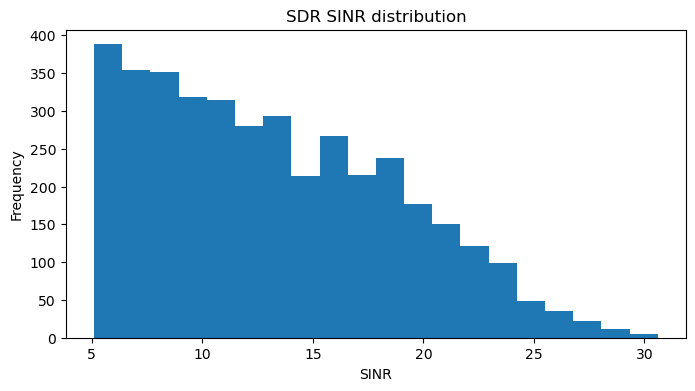

In [8]:
# print the last item in the dataset
print(f'Shape of the received symbols tensor: {dataset.pdsch_iq[-1].shape},  and original modulated bits tensor {dataset.labels[-1].shape}') 

if use_sdr:
    plt.figure(figsize=(8, 4))
    plt.hist(SINR_stats, bins=20)
    plt.xlabel('SINR')
    plt.ylabel('Frequency')
    plt.title('SDR SINR distribution')

In [9]:
torch.zeros(2 + 1, dtype=torch.complex64)
torch.randint(0,3, (1,)).item()

2